# Sentiment classification

In this part, we perform sentiment classification to classify our data set into positive and negative sentiments. Our main model is the Naive Bayes classifier implemented by nltk. However, we aim to find the best performing model based on several parameters such as the four feature extraction methods that we have implemented, the text normalisation methods and the optimal n value of the most significant words.

In [1]:
# import libraries
import numpy as np
import collections
from nltk.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from wordcloud import WordCloud

In [2]:
%run preprocessing.ipynb # import pre-processing.ipynb to use the data sets and functions

There are 2 data frames to be used for classification:
BG_stem
BG_lemma

There are 4 feature extraction methods:
unigram_features:                   all words
bigram_features:                    all words and most significant bigrams
informative_word_features:          most significant words only
informative_word_bigram_features:   most significant words and bigrams


In [3]:
def cross_validate(df, clss, feature_function, n):
    # informative or most significant words
    global inform_words
    inform_words = informative_words(df, n)
    
    # create positive and negative features
    negfeats = feature_extract(df, feature_function, 'Negative')
    posfeats = feature_extract(df, feature_function, 'Positive')
    
    # X is the features, y is the labels
    X = negfeats + posfeats
    y = df['sentiment']
    
    # split into train test with a ratio of 80:20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=None, stratify=y)

    k = 10
    skf = StratifiedKFold(n_splits=k, random_state=None)
    y_true = []
    y_score = []
    accuracy = []
    aucs = []
    
    def label2int(label):
        if label == 'Positive':
            return 1
        else:
            return 0
    
    classifier_dict = {NaiveBayes: 'Naive Bayes', LinearSVC: 'LinearSVC', 
                       SVC: 'SVC', LogisticRegression: 'Logistic Regression', NuSVC: 'NuSVC'}
    
    # stratified k-fold cross validation
    for train, validate in skf.split(X_train, y_train):
        train_data = np.array(X_train)[train]
        validate_data = np.array(X_train)[validate]
        if clss == NaiveBayes:
            classifier = clss.train(train_data)
        else:
            classifier = clss
            classifier._vectorizer.sort = False
            classifier.train(train_data)

        for i, (feats, label_true) in enumerate(validate_data):
            label_predicted = classifier.classify(feats)
            y_true.append(label2int(label_true))
            y_score.append(label2int(label_predicted))
        
        # calculating accuracy
        cv_accuracy = nltk.classify.util.accuracy(classifier, validate_data)
        accuracy.append(cv_accuracy)
        
        # calculating ROC AUC
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        

    print('----------------------------------')
    print('10-Fold Cross Validation Result:')
    print('----------------------------------')
    print('Classifier:', classifier_dict[clss])
    print('Parameters: {}, {}'.format(df.name, feature_function.__name__))
    print('Accuracy:', sum(accuracy)/k)
    print('ROC AUC:', sum(aucs)/k)

The data sets are first split into an 80:20 ratio of train:test sets. The testing set is left out as to avoid leakage of information from the training set. The training set is then evaluated using a 10-fold stratified cross validation to find the best parameters.

In [4]:
# feature extraction methods
feature_list = [unigram_features, bigram_features, informative_word_features, informative_word_bigram_features]

In [5]:
# data frames
BG_list = [BG_stem, BG_lemma]

In [6]:
# classifiers
NaiveBayes = nltk.NaiveBayesClassifier
LinearSVC = SklearnClassifier(LinearSVC())
SVC = SklearnClassifier(SVC())
LogisticRegression = SklearnClassifier(LogisticRegression())
NuSVC = SklearnClassifier(NuSVC())

classifier_list = [NaiveBayes, LinearSVC, SVC, LogisticRegression, NuSVC]

To find the model with the best result, we need to try different combinations of parameters. The parameters are whether the data set was lemmatised or stemmed, the feature extraction method and the number of informative words, n. Apart from that, we also try to find which of the classifiers that would perform the best with our chosen parameters. The metrics that we use are accuracy and ROC AUC.

We know that the parameter that will best improve the model is the feature extraction. Therefore, we first try to run the model with 30 most significant words (which we estimate as the optimal n value) iterating over all four feature functions. We use Naive Bayes as our initial model.

In [17]:
inform_words

{'always',
 'arrive',
 'clean',
 'courteous',
 'easy',
 'effici',
 'efficient',
 'efficiently',
 'engineer',
 'excel',
 'excellent',
 'friend',
 'friendly',
 'good',
 'great',
 'helpful',
 'job',
 'pleasant',
 'polit',
 'polite',
 'problem',
 'professional',
 'prompt',
 'quick',
 'quickly',
 'recommend',
 'servic',
 'service',
 'thorough',
 'tidy'}

In [7]:
# first we start with stemmed data
print('Stemmed data set')
for feat in feature_list:
    np.random.seed(6)
    cross_validate(BG_stem, NaiveBayes, feat, 30)

Stemmed data set
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_stem, unigram_features
Accuracy: 0.6123987279473007
ROC AUC: 0.6292554870346165
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_stem, bigram_features
Accuracy: 0.7310542389137075
ROC AUC: 0.7496265311286929
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_stem, informative_word_features
Accuracy: 0.625612680144368
ROC AUC: 0.6109850648555355
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_stem, informative_word_bigram_features
Accuracy: 0.9090696852679135
ROC AUC: 0.90878944707185


In [8]:
# and lemmatised data next
print('Lemmatised data set')
for feat in feature_list:
    np.random.seed(6)
    cross_validate(BG_lemma, NaiveBayes, feat, 30)

Lemmatised data set
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, unigram_features
Accuracy: 0.6262512304081169
ROC AUC: 0.6450552829488583
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, bigram_features
Accuracy: 0.7310517149996214
ROC AUC: 0.7511453902410292
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, informative_word_features
Accuracy: 0.5701950985588451
ROC AUC: 0.5490778541504774
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.9111948209282955
ROC AUC: 0.9148360232469507


In both the stemmed and lemmatised data sets, informative_word_bigram_features seem to yield the best result with an accuracy and ROC AUC of more than 90%. Lemmatised's metric scores are higher than stemmed's albeit by a really small margin. This is especially beneficial to us as stemming can sometimes lose valuable information.

Hence, we choose lemmatisation as our text normalisation method and informative_word_bigram_features as our feature extraction for BG_df. We see if we can improve the scores by increasing the n most significant words to n = 100 and n = 200.

In [9]:
n_list = [100, 200]
for n in n_list:
    np.random.seed(6)
    print('\nn =', n)
    cross_validate(BG_lemma, NaiveBayes, informative_word_bigram_features, n)


n = 100
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.8959125211377804
ROC AUC: 0.9030221496161326

n = 200
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.8703263420913151
ROC AUC: 0.8812610915850756


It seems that increasing the n value decreases the accuracy and ROC AUC. We will stick with n = 30. Now, after we have found the best combination of parameters, let's try to fit different classifiers to our data set.

In [10]:
# testing the classifiers with our best parameters
for classifier in classifier_list:
    np.random.seed(6)
    cross_validate(BG_lemma, classifier, informative_word_bigram_features, 30)

----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.9115519547714597
ROC AUC: 0.9144504991483673
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: LinearSVC
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.8245198253451452
ROC AUC: 0.8207307559525988
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: SVC
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.5151195073319703
ROC AUC: 0.5
----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Logistic Regression
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.8529277403397189
ROC AUC: 0.8503676365322249
----------------------------------
10-Fold Cross Validation R

Naive Bayes seems to be the best performing algorithm. Therefore, our best model for BG_df is Naive Bayes as the algorithm, lemmatisation as the text normalisation technique, and most significant words and bigrams as the features where their numbers are capped at 30. 

In [11]:
def metrics(df, clss, feature_function, n):
    # informative or most significant words
    global inform_words
    inform_words = informative_words(df, n)
    
    # create positive and negative features
    negfeats = feature_extract(df, feature_function, 'Negative')
    posfeats = feature_extract(df, feature_function, 'Positive')
    
    # X is the features, y is the labels
    X = negfeats + posfeats
    y = df['sentiment']
    
    # split into train test with a ratio of 80:20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=None, stratify=y)
    
    y_true = []
    y_score = []
    accuracy = []
    aucs = []
    
    def label2int(label):
        if label == 'Positive':
            return 1
        else:
            return 0
    
    classifier_dict = {NaiveBayes: 'Naive Bayes', LinearSVC: 'LinearSVC', 
                       SVC: 'SVC', LogisticRegression: 'Logistic Regression', NuSVC: 'NuSVC'}
    
    if clss == NaiveBayes:
        classifier = clss.train(X_train)
    else:
        classifier = clss
        classifier._vectorizer.sort = False
        classifier.train(X_train)

    for i, (feats, label_true) in enumerate(X_test):
        label_predicted = classifier.classify(feats)
        y_true.append(label2int(label_true))
        y_score.append(label2int(label_predicted))
        
    # calculating accuracy
    accuracy = nltk.classify.util.accuracy(classifier, X_test)

    # calculating ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)        

    print('----------------------------------')
    print('10-Fold Cross Validation Result:')
    print('----------------------------------')
    print('Classifier:', classifier_dict[clss])
    print('Parameters: {}, {}'.format(df.name, feature_function.__name__))
    print('Accuracy:', accuracy)
    print('ROC AUC:', roc_auc)
    print(classifier.show_most_informative_features(55))

Let's see how our model generalise to the unseen test set. The metrics function will test the metric scores against the 20% of the original data set that was left out.

In [12]:
np.random.seed(6)
metrics(BG_lemma, NaiveBayes, informative_word_bigram_features, 30)

----------------------------------
10-Fold Cross Validation Result:
----------------------------------
Classifier: Naive Bayes
Parameters: BG_lemma, informative_word_bigram_features
Accuracy: 0.9176136363636364
ROC AUC: 0.9196838905775075
Most Informative Features
('excellent', 'service') = True           Positi : Negati =     25.8 : 1.0
        ('arrive', 'on') = True           Positi : Negati =     23.2 : 1.0
     ('direct', 'debit') = True           Negati : Positi =     22.0 : 1.0
  ('engineer', 'arrive') = True           Positi : Negati =     17.6 : 1.0
                    tidy = True           Positi : Negati =     17.5 : 1.0
                thorough = True           Positi : Negati =     15.6 : 1.0
                friendly = True           Positi : Negati =     14.7 : 1.0
           ('2', 'week') = True           Negati : Positi =     14.5 : 1.0
               excellent = True           Positi : Negati =     14.0 : 1.0
    ('happy', 'service') = True           Positi : Negati = 

The model generalises really well with unseen data with an accuracy and ROC AUC of 91.2%. There doesn't seem to be any overfit occuring and the most informative features also provides us with good information on both the positive and negative aspects of British Gas.

Let us visualise the predictive features by using a word cloud that separates the colour of positive and negative feature predictors. 

We take the first 25 features that are predictive for both positive and negative. We remove the bigram 'recommend british' from our list since we know this analysis is about British Gas and recommend refers to positive. Instead, we take the next feature 'service boiler' which gives us more information.

We clean it up in an excel spreadsheet and save it to features.csv.

In [13]:
feature_df = pd.read_csv('..\\Dissertation_Code\\features.csv')
feature_df.head()

,Features,Sentiment,Ratio
0,excellent service,Positive,25.8
1,arrive on,Positive,23.2
2,direct debit,Negative,22.0
3,engineer arrive,Positive,17.6
4,thorough,Positive,15.6


We shall use the features' ratio of informativeness given by our classifier.

In [14]:
# create dictionary with features as key and ratio, sentiment as value
d = feature_df.set_index('Features').to_dict()['Ratio']
c = feature_df.set_index('Features').to_dict()['Sentiment']

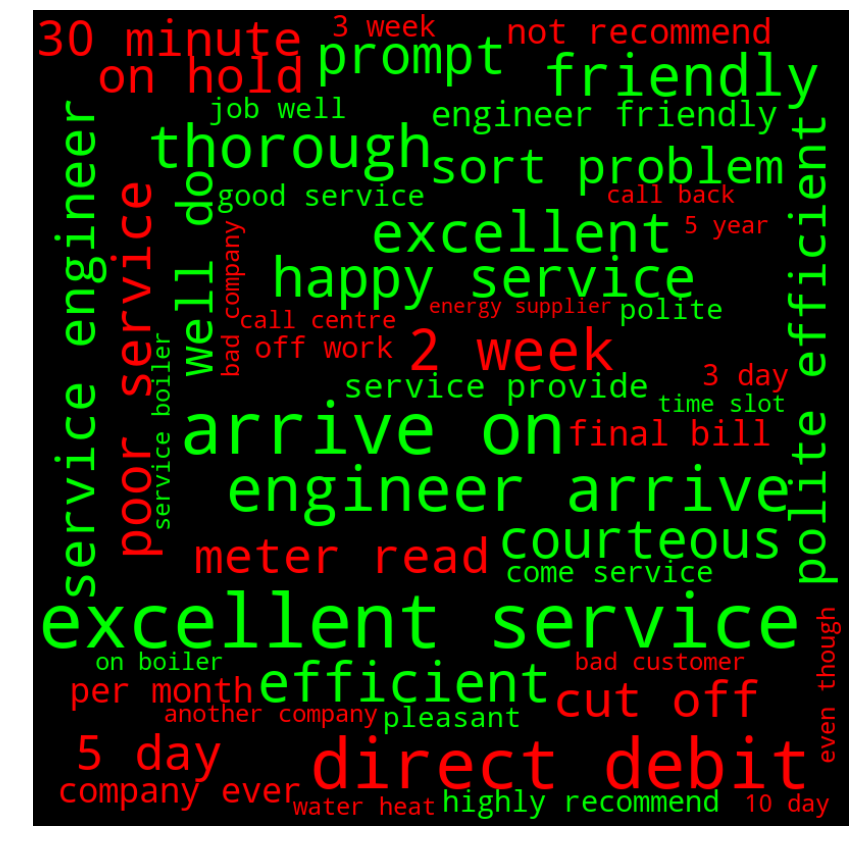

In [15]:
# define color, green for positive and red for negative
def color_func(word, *args, **kwargs):
    if c[word] == 'Negative':
        color = '#ff0000' # red
    else:
        color = '#00ff00' # green
    return color

# create wordcloud
wordcloud = WordCloud(width=800, height=800, color_func=color_func)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From the above word cloud, there are certain things that we can learn about the positive and negative sentiments in regards to British Gas. For example, the engineer service seems to be on the positive side while the customer service seems to be on the negative side. 

There are also a few numbers or time periods emerging within the word cloud. Since they have been occuring alot, there must be a common pattern which we can learn about. We shall peform further analysis in analysis.ipynb to understand the meaning behind these numbers.

Next, we apply Latent Dirichlet Allocation, a topic modelling technique to our BG_lemma data frame in lda.ipynb.